# **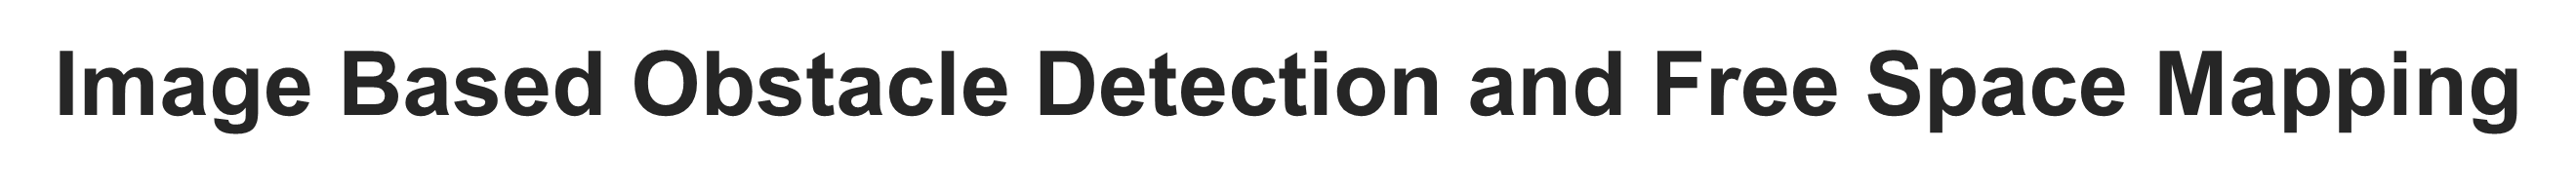**

## **INPUT IMAGE**

Saving img_09.jpeg to img_09.jpeg


(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

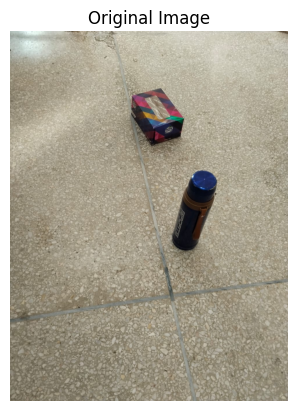

In [ ]:
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")


## **PRE PROCESSING**

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

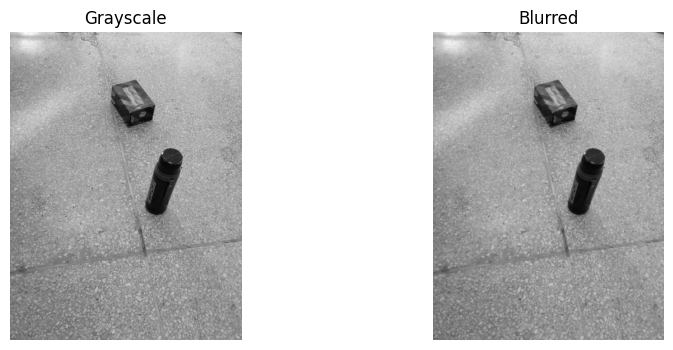

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(blur, cmap='gray')
plt.title("Blurred")
plt.axis("off")


## **EDGE DETECTION**

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

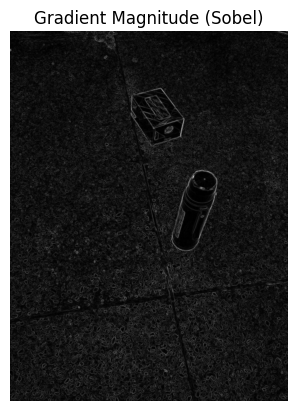

In [ ]:
sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

plt.imshow(gradient_magnitude, cmap='gray')
plt.title("Gradient Magnitude (Sobel)")
plt.axis("off")


## **OBSTACLE DETECTION**

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

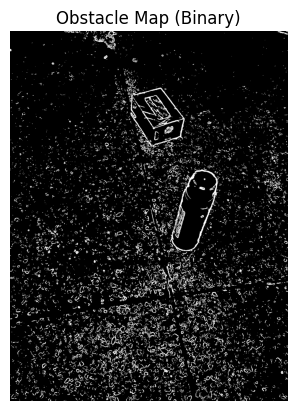

In [ ]:
_, obstacle_map = cv2.threshold(gradient_magnitude.astype(np.uint8),
                                40, 255, cv2.THRESH_BINARY)

plt.imshow(obstacle_map, cmap='gray')
plt.title("Obstacle Map (Binary)")
plt.axis("off")


## **FREE SPACE MAPPING**

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

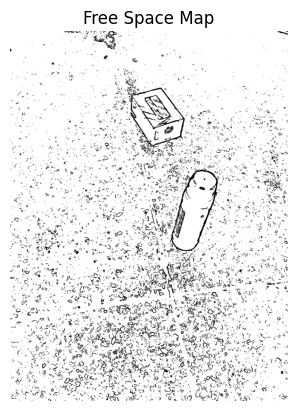

In [ ]:
free_space = cv2.bitwise_not(obstacle_map)

plt.imshow(free_space, cmap='gray')
plt.title("Free Space Map")
plt.axis("off")


## **OCCUPANCY GRID GENERATION**

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

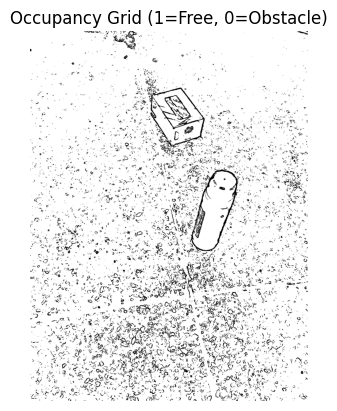

In [ ]:
occupancy_grid = np.zeros_like(free_space)
occupancy_grid[free_space == 255] = 1   # free space = 1
occupancy_grid[obstacle_map == 255] = 0 # obstacle = 0

plt.imshow(occupancy_grid, cmap='gray')
plt.title("Occupancy Grid (1=Free, 0=Obstacle)")
plt.axis("off")


## **PATH PLANNING**

In [ ]:
from collections import deque

def bfs(grid, start, goal):
    rows, cols = grid.shape
    visited = np.zeros_like(grid)
    parent = {}

    q = deque([start])
    visited[start] = 1

    while q:
        r, c = q.popleft()
        if (r, c) == goal:
            break
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                if grid[nr,nc] == 1 and not visited[nr,nc]:
                    visited[nr,nc] = 1
                    parent[(nr,nc)] = (r,c)
                    q.append((nr,nc))

    path = []
    node = goal
    while node != start:
        path.append(node)
        node = parent.get(node)
        if node is None:
            return []
    path.append(start)
    return path[::-1]


(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

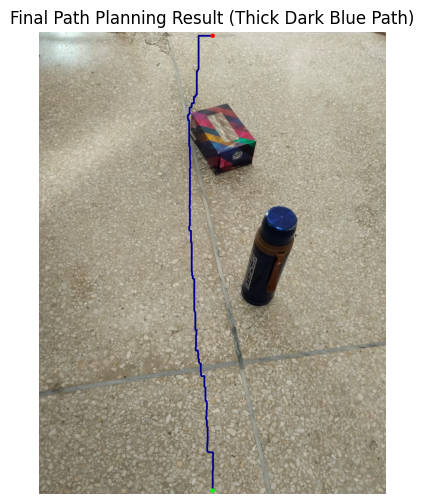

In [ ]:
path_img = img.copy()

for i in range(len(path)-1):
    r1, c1 = path[i]
    r2, c2 = path[i+1]

    # Draw thick line between consecutive points
    cv2.line(
        path_img,
        (c1, r1),      # (x, y)
        (c2, r2),
        color=(0, 0, 139),  # dark blue
        thickness=4        # increase thickness here
    )

# Draw start and goal points
cv2.circle(path_img, (start[1], start[0]), 6, (0,255,0), -1)  # green start
cv2.circle(path_img, (goal[1], goal[0]), 6, (255,0,0), -1)   # red goal

plt.figure(figsize=(8,6))
plt.imshow(path_img)
plt.title("Final Path Planning Result (Thick Dark Blue Path)")
plt.axis("off")


## **RESULTS AND EVALUATION**

In [ ]:
import time
import numpy as np

# -------------------------
# 1. Define start and goal points
# -------------------------
start = (occupancy_grid.shape[0]-10, occupancy_grid.shape[1]//2)
goal = (10, occupancy_grid.shape[1]//2)

# -------------------------
# 2. Run BFS Path Planning and Measure Time
# -------------------------
start_time = time.time()
path = bfs(occupancy_grid, start, goal)
end_time = time.time()
processing_time = end_time - start_time

# -------------------------
# 3. Accuracy: Obstacle / Free-space detection
# -------------------------
# Simple pixel-based accuracy (1=correct free-space, 0=obstacle)
total_pixels = occupancy_grid.size
correct = np.sum(occupancy_grid == (free_space//255))
accuracy = (correct / total_pixels) * 100

# -------------------------
# 4. Path Efficiency: Length & collisions
# -------------------------
path_length = len(path)
collisions = 0
for r,c in path:
    if occupancy_grid[r,c] == 0:
        collisions += 1

path_efficiency = "Collision-Free" if collisions==0 else f"{collisions} collisions!"

# -------------------------
# 5. Print Results
# -------------------------
print("===== SYSTEM PERFORMANCE METRICS =====")

print(f"Path Length (pixels): {path_length}")
print(f"Path Efficiency: {path_efficiency}")
print(f"Processing Time: {processing_time:.4f} seconds")
# Erode obstacles slightly to remove edge noise
kernel = np.ones((3,3), np.uint8)
obstacle_eroded = cv2.erode(obstacle_map, kernel, iterations=1)
free_space_eroded = cv2.bitwise_not(obstacle_eroded)

# Accuracy
correct = np.sum(occupancy_grid == (free_space_eroded//255))
accuracy = (correct / total_pixels) * 100
print(f"Free-Space / Obstacle Detection Accuracy: {accuracy:.2f}%")



===== SYSTEM PERFORMANCE METRICS =====
Path Length (pixels): 1421
Path Efficiency: Collision-Free
Processing Time: 3.9799 seconds
Free-Space / Obstacle Detection Accuracy: 92.78%
